# Stix Dispersion Solver

[stix]: ../../api_static/plasmapy.dispersion.analytical.stix_.rst
[bellan2012]: https://doi.org/10.1029/2012JA017856
[stix1992]: https://link.springer.com/book/9780883188590

This notebook details the functionality of the [stix()][stix] function. This is an analytical solution of equation 8 in [Bellan 2012][bellan2012], the function is defined by Stix [1992] in section 1-3 to be:

$$
        (S\sin^{2}(\theta) + P\cos^{2}(\theta))(ck/\omega)^{4}
            - [
                RL\sin^{2}(\theta) + PS(1 + \cos^{2}(\theta))
            ](ck/\omega)^{2} + PRL = 0
$$
where,

$$
        \mathbf{B_o} = B_{o} \mathbf{\hat{z}}   
         \cos \theta = \frac{k_z}{k} \\
        \mathbf{k} = k_{\rm x} \hat{x} + k_{\rm z} \hat{z}
$$

$$
        S = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega^{2}_{c,s}}\hspace{2.5cm}
        P = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2}}\hspace{2.5cm}
        D = \sum_{s}
            \frac{\omega_{c,s}}{\omega}
            \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega_{c,s}^{2}}
$$

$$
        R = S + D \hspace{1cm} L = S - D
$$

$\omega$ is the wave frequency, $k$ is the wavenumber, $\theta$ is the wave propagation angle with respect to the background magntic field $\mathbf{B_o}$, $s$ corresponds to plasma species $s$, $\omega_{p,s}$ is the plasma frequency of species $s$, and $\omega_{c,s}$ is the gyrofrequency of species $s$.

<div class="alert alert-info">
Note

The derivation of this dispersion relation assumed: 
* zero temperature for all plasma species ($T_{s}=0$)
* quasi-neutrallity
* a uniform background magntic field $\mathbf{B_o} = B_{o} \mathbf{\hat{z}}$
* no D.C. electric field $\mathbf{E_o}=0$
* zero-order quantities for all plasma parameters (densities, electric-field, magnetic field, particle speeds, etc.) are constant in time and space
* first-order perturbations in plasma parameters vary like $\sim e^{\left [ i (\textbf{k}\cdot\textbf{r} - \omega t)\right ]}$
    
</div>  

Due to the cold plasma assumption, this equation is valid for all $\omega$ and $k$ given $\frac{\omega}{k_{z}} \gg v_{Th}$ for all thermal speeds $v_{Th}$ of all plasma species and $k_{x} r_{L} \ll 1$ for all gyroradii $r_{L}$ of all plasma species. The relation predicts $k \to 0$ when any one of P, R or L vanish (cutoffs) and $k \to \infty$ for perpendicular propagation during wave resonance $S \to 0$.
 

## Contents

1. [Wave Normal to the Surface](#Wave-normal-to-the-surface)
2. [Comparision with Bellan](#Comparision-with-bellan)
3. 

In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants.si import c
from plasmapy.particles import Particle
from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.dispersion.numerical.two_fluid_ import two_fluid


## Wave Normal to the Surface

Below we define the required parameters to compute the wave numbers.

In [2]:
# define input parameters
inputs_1 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("Ar+"),],
    "n_i": [2.0e12,] * u.cm**-3,
    "B": 0.43463 * np.sqrt(2) * u.T,
    "w": 500000 * 2 * np.pi * u.rad / u.s,
}

# define a meshgrid based on the number of theta values
omegas, thetas = np.meshgrid(
    inputs_1["w"].value, inputs_1["theta"].value, indexing="ij"
)
omegas = np.dstack((omegas,)*4).squeeze()
thetas = np.dstack((thetas,)*4).squeeze()

# compute k values
k = stix(**inputs_1)

[Quantity]: https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity

The computed wavenubmers in units (rad/m) are returned in a dictionary (shape $N \times M \times 4$), with the keys representing $\theta$ and the values (instances of Astropy [Quantity]) being the wavenumbers. The first dimension maps to the $w$ array, the second dimension maps to the $theta$ array, and the third dimension maps to the four roots of the Stix polynomial.
* $k[0]$ is the square root of the positive quadratic solution
* $k[1] = -k[0]$
* $k[2]$ is the square root of the negative quadratic solution
* $k[3] = -k[2]$

Below the values for $u_{x}$ and $u_{z}$ are calculated.

In [3]:
# calculate ux and uz
mask = np.imag(k) == 0
ux = omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value)
uz = omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value)


Let's plot the results.

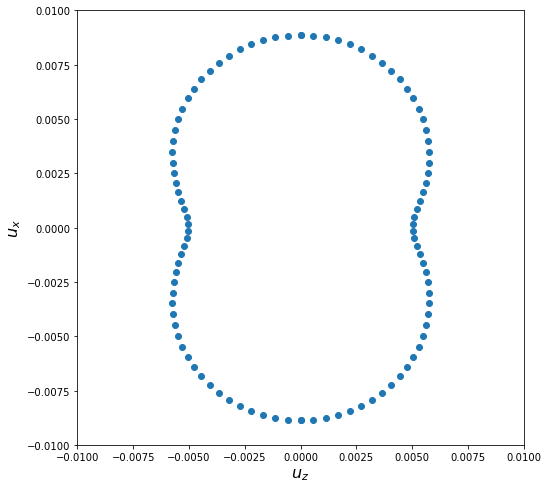

In [5]:
# plotting the results
plt.figure(figsize=(8, 8))
plt.scatter(ux, uz)
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)
plt.ylabel(r'$u_{x}$', fontsize=16)
plt.xlabel(r'$u_{z}$', fontsize=16)
plt.show()

Following on, the figures from Stix [1992]can be reproduced.

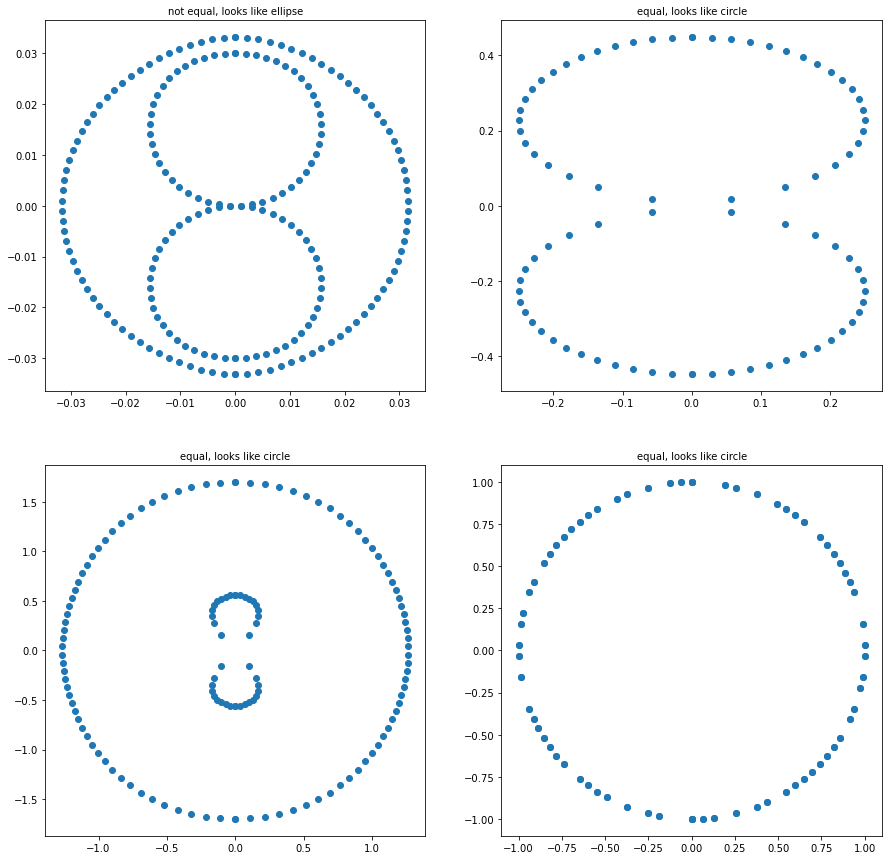

In [41]:
# define inputs
inputs_2 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("p")],
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (41632 * 10**2) * u.rad / u.s,
}

inputs_3 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("p")],
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (124896 * 10**5) * u.rad / u.s,
}

inputs_4 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("p")],
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (4136 * 10**7) * u.rad / u.s,
}

inputs_5 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("p")],
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (10 * 10**7) * u.rad / u.s,
}

inputs = [inputs_2, inputs_3, inputs_4, inputs_5]
ux = {}
uz = {}

for i in range(len(inputs)):
    omegas, thetas = np.meshgrid(
        inputs[i]["w"].value, inputs[i]["theta"].value, indexing="ij"
    )
    omegas = np.dstack((omegas,)*4).squeeze()
    thetas = np.dstack((thetas,)*4).squeeze()

    k = stix(**inputs[i])

    mask = np.imag(k) == 0
    ux[i] = omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value)
    uz[i] = omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value)



fig, axs = plt.subplots(2, 2, figsize=(15, 15))


axs[0, 0].scatter(ux[0], uz[0])
axs[0, 0].set_title('not equal, looks like ellipse', fontsize=10)

axs[0, 1].scatter(ux[1], uz[1])
axs[0, 1].set_title('equal, looks like circle', fontsize=10)

axs[1, 0].scatter(ux[2], uz[2])
axs[1, 0].set_title('equal, looks like circle', fontsize=10)

axs[1, 1].scatter(ux[3], uz[3])
axs[1, 1].set_title('equal, looks like circle', fontsize=10)


plt.show()

## Comparision with Bellan

Below we run a comparision between the solution provided in Bellan [2012] and our own solutions computed from [stix()][stix].  

In [ ]:
inputs_6 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("Ar+"),],
    "n_i": [2.0e12,] * u.cm**-3,
    "B": 0.43463 * np.sqrt(2) * u.T,
    "w": 500000 * 2 * np.pi * u.rad / u.s,
}



two fluid
cold and warm plasma limits
change previous plots to line plots